In [11]:
import os, json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support


In [12]:
def load_labels(model_dir):
    with open(os.path.join(model_dir, "label_map.json"), "r", encoding="utf-8") as f:
        m = json.load(f)
    id2label = {int(k): v for k, v in m["id2label"].items()}
    return id2label

def try_load_keras(model_dir):
    return tf.keras.models.load_model(model_dir, compile=False)

def try_load_savedmodel(model_dir):
    sm = tf.saved_model.load(model_dir)
    infer = sm.signatures.get("serving_default", None)
    if infer is None:
        raise ValueError("No 'serving_default' signature in SavedModel.")
    return infer


In [13]:
def load_labels(model_dir):
    with open(os.path.join(model_dir, "label_map.json"), "r", encoding="utf-8") as f:
        m = json.load(f)
    id2label = {int(k): v for k, v in m["id2label"].items()}
    return id2label

def try_load_keras(model_dir):
    return tf.keras.models.load_model(model_dir, compile=False)

def try_load_savedmodel(model_dir):
    sm = tf.saved_model.load(model_dir)
    infer = sm.signatures.get("serving_default", None)
    if infer is None:
        raise ValueError("No 'serving_default' signature in SavedModel.")
    return infer


In [14]:
def predict_texts(model_or_fn, id2label, texts, batch_size=32, is_keras=True):
    if is_keras:
        ds = tf.data.Dataset.from_tensor_slices(texts).batch(batch_size)
        probs = model_or_fn.predict(ds)
    else:
        try:
            out = model_or_fn(text=tf.constant(texts, dtype=tf.string)[:, None])
        except Exception:
            out = model_or_fn(text=tf.constant(texts, dtype=tf.string))
        probs = next(iter(out.values())).numpy()

    idx = probs.argmax(axis=1)
    conf = probs[np.arange(len(texts)), idx]
    labels = [id2label[int(i)] for i in idx]
    return labels, conf, probs


In [15]:
def predict_texts(model_or_fn, id2label, texts, batch_size=32, is_keras=True):
    if is_keras:
        ds = tf.data.Dataset.from_tensor_slices(texts).batch(batch_size)
        probs = model_or_fn.predict(ds)
    else:
        try:
            out = model_or_fn(text=tf.constant(texts, dtype=tf.string)[:, None])
        except Exception:
            out = model_or_fn(text=tf.constant(texts, dtype=tf.string))
        probs = next(iter(out.values())).numpy()

    idx = probs.argmax(axis=1)
    conf = probs[np.arange(len(texts)), idx]
    labels = [id2label[int(i)] for i in idx]
    return labels, conf, probs


In [16]:
# đường dẫn model & file CSV
model_dir = "bilstm_vn_sentiment_5cls"
csv_file = "/home/dat/llm_ws/data/test/test.csv"   # file CSV có cột 'text' và 'label'

# load label map
id2label = load_labels(model_dir)

# load model
is_keras = True
try:
    model_or_fn = try_load_keras(model_dir)
except:
    model_or_fn = try_load_savedmodel(model_dir)
    is_keras = False

# đọc dữ liệu
df = pd.read_csv(csv_file)
texts = df["text"].astype(str).tolist()
true_labels = df["label"].tolist()

# dự đoán
pred_labels, conf, probs = predict_texts(model_or_fn, id2label, texts, is_keras=is_keras)


2025-11-14 02:01:34.534921: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2025-11-14 02:01:35.098412: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2025-11-14 02:01:35.157584: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2025-11-14 02:01:35.161710: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2025-11-14 02:01:35.207039: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond/while' has 14 outputs but the _output_sh

10/10 [==============================] - 1s 12ms/step


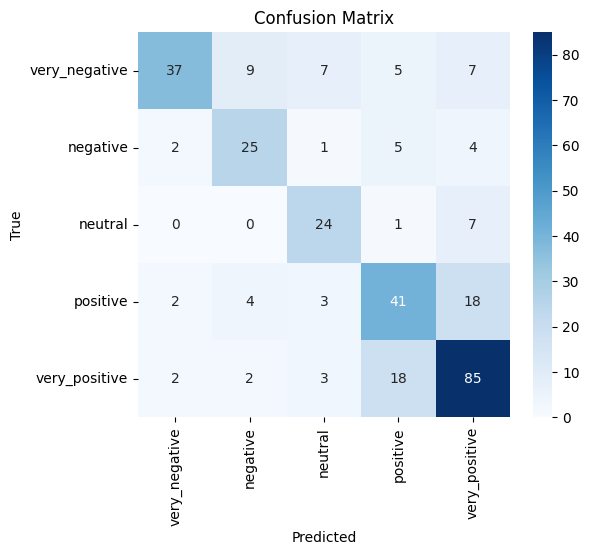

In [17]:
cm = confusion_matrix(true_labels, pred_labels, labels=list(id2label.values()))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(id2label.values()),
            yticklabels=list(id2label.values()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [19]:
print("Classification Report:")
print(classification_report(true_labels, pred_labels, digits=3))

accuracy = accuracy_score(true_labels, pred_labels)
prec, rec, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-score: {f1:.3f}")


Classification Report:
               precision    recall  f1-score   support

          nan      0.000     0.000     0.000         1
     negative      0.625     0.676     0.649        37
      neutral      0.632     0.750     0.686        32
     positive      0.586     0.603     0.594        68
very_negative      0.860     0.569     0.685        65
very_positive      0.697     0.773     0.733       110

     accuracy                          0.677       313
    macro avg      0.567     0.562     0.558       313
 weighted avg      0.689     0.677     0.676       313

Accuracy: 0.677
Precision: 0.689
Recall: 0.677
F1-score: 0.676


/home/dat/llm_ws/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dat/llm_ws/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dat/llm_ws/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dat/llm_ws/.venv/lib/pyth

In [25]:
import time
import tensorflow as tf
import numpy as np
import json
import os
import tensorflow as tf

# ===============================================
# CONFIG
# ===============================================
MODEL_DIR = "/home/dat/llm_ws/bilstm/bilstm_vn_sentiment_5cls"
TEST_TEXT = "Sản phẩm dùng khá ổn, chất lượng tạm chấp nhận được."
N = 1000  # số lần lặp để đo thời gian
# ===============================================

DEFAULT_LABELS = ["negative", "neutral", "positive"]

def load_savedmodel(model_dir):
    obj = tf.saved_model.load(model_dir)
    infer = obj.signatures.get("serving_default")
    if infer is None:
        raise RuntimeError("No 'serving_default' signature found.")
    return infer

def load_label_map(model_dir):
    lm_path = os.path.join(model_dir, "label_map.json")
    if os.path.exists(lm_path):
        with open(lm_path, "r", encoding="utf-8") as f:
            lm = json.load(f)
        id2label = {int(k): v for k, v in lm["id2label"].items()}
    else:
        id2label = {i: lab for i, lab in enumerate(DEFAULT_LABELS)}
    return id2label

def predict_one_tf(infer, id2label, text):
    outs = infer(text=tf.constant([[text]], dtype=tf.string))
    y = list(outs.values())[0].numpy()[0]
    pred_id = int(np.argmax(y))
    return id2label[pred_id], float(y[pred_id]), y


# === Load model ===
id2label = load_label_map(MODEL_DIR)
infer = load_savedmodel(MODEL_DIR)

# === Warm-up ===
_ = predict_one_tf(infer, id2label, TEST_TEXT)

# === Inference 1000 lần ===
t0 = time.time()
for _ in range(N):
    _ = predict_one_tf(infer, id2label, TEST_TEXT)
t1 = time.time()

total_time = t1 - t0
avg_time = total_time / N

# === Chạy một lần để in kết quả cho đẹp ===
lbl, conf, probs = predict_one_tf(infer, id2label, TEST_TEXT)
ranked = sorted([(id2label[i], float(p)) for i, p in enumerate(probs)],
                key=lambda x: x[1], reverse=True)

print("===== TensorFlow SavedModel Inference =====")
print("Model dir    :", MODEL_DIR)
print("Test text    :", TEST_TEXT)
print("Prediction   :", lbl)
print("Confidence   :", f"{conf:.4f}\n")

print(f"Số lần lặp     : {N}")
print(f"Tổng thời gian : {total_time:.4f} s")
print(f"Thời gian 1 câu: {avg_time*1000:.2f} ms")

print("\nProbabilities:")
for lab, p in ranked:
    print(f" - {lab:12s}: {p:.4f}")



2025-11-14 02:26:38.937967: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2025-11-14 02:26:39.231182: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2025-11-14 02:26:39.290148: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2025-11-14 02:26:39.294492: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2025-11-14 02:26:39.341732: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond/while' has 14 outputs but the _output_sh

===== TensorFlow SavedModel Inference =====
Model dir    : /home/dat/llm_ws/bilstm/bilstm_vn_sentiment_5cls
Test text    : Sản phẩm dùng khá ổn, chất lượng tạm chấp nhận được.
Prediction   : neutral
Confidence   : 0.9859

Số lần lặp     : 1000
Tổng thời gian : 3.3354 s
Thời gian 1 câu: 3.34 ms

Probabilities:
 - neutral     : 0.9859
 - positive    : 0.0140
 - very_positive: 0.0000
 - very_negative: 0.0000
 - negative    : 0.0000
